In [2]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import csv 
import io
import pandas as pd
from pandas.compat import StringIO, BytesIO
import time #time.time() function to compute time

### Functions reading Nanonis files

In [3]:
def read_nanonis_experiment(filename):
    import pandas as pd
    with open(filename, "rb") as data_file:
        dummy_file = data_file.read()

        position = dummy_file.find(b'Experiment')
        data_file.seek(position)
        #data_type = data_file.readline().decode('ascii').split()[1:]
        data_type = data_file.readline().decode('ascii')[11:]
    return data_type

def read_nanonis_curve(filename):
    import pandas as pd
    with open(filename, "rb") as data_file:
        dummy_file = data_file.read()

        position = dummy_file.find(b'[DATA]')
        data_file.seek(position)
        data_file.readline()
        data_table = data_file.read().decode('ascii')
    curve=pd.read_csv(StringIO(data_table), sep='\t')
    return curve

#### Testing Nanonis functions

In [4]:
file_name = "Freq-Sweep-Nanonis.dat"
file_name = './RawData/Bias-Spectroscopy00014.dat'
freq_sweep = read_nanonis_curve(file_name)
print(read_nanonis_experiment(file_name))
freq_sweep.head()

bias spectroscopy	



,Bias calc (V),OC D1 Amplitude (m),OC M1 Freq. Shift (Hz),OC D1 Amplitude [bwd] (m),OC M1 Freq. Shift [bwd] (Hz)
0,-1.000000,9.836363e-08,-56.129826,9.883544e-08,-56.006950
1,-0.992157,9.835121e-08,-56.700848,9.886181e-08,-56.248611
2,-0.984314,9.834855e-08,-55.291229,9.888624e-08,-57.167732
3,-0.976471,9.834528e-08,-55.480934,9.891335e-08,-56.220547
4,-0.968627,9.834302e-08,-55.509113,9.893257e-08,-54.839935


#### Parameters and file names

In [5]:
n0 = 14; nfiles = 5;
file_folder = './RawData';
file_name_root = 'Bias-Spectroscopy';
file_name_ext = '.dat';
file_name = [];
for i in range(nfiles):
    name_string = file_folder + '/' + file_name_root + str('%05d' % (i+n0)) + file_name_ext
    file_name.append(name_string)
    
file_name

['./RawData/Bias-Spectroscopy00014.dat',
 './RawData/Bias-Spectroscopy00015.dat',
 './RawData/Bias-Spectroscopy00016.dat',
 './RawData/Bias-Spectroscopy00017.dat',
 './RawData/Bias-Spectroscopy00018.dat']

In [6]:
n0 = 194; nfiles = 5;
file_folder = './RawData';
file_name_root = 'Z-Spectroscopy';
file_name_ext = '.dat';
file_name_z = [];
for i in range(nfiles):
    name_string = file_folder + '/' + file_name_root + str('%05d' % (i+n0)) + file_name_ext
    file_name_z.append(name_string)
    
file_name_z

['./RawData/Z-Spectroscopy00194.dat',
 './RawData/Z-Spectroscopy00195.dat',
 './RawData/Z-Spectroscopy00196.dat',
 './RawData/Z-Spectroscopy00197.dat',
 './RawData/Z-Spectroscopy00198.dat']

In [7]:
bias = [];
delta_f_fwd = [];
delta_f_bwd = [];
for n in range(nfiles): 
    with open(file_name[n], "rb") as data_file:
        #string = b'[DATA]'
        dummy_file = data_file.read()
        #print(file)

        
        position = dummy_file.find(b'[DATA]')
        data_file.seek(position)
        data_file.readline()
        data_table = data_file.read().decode('ascii')
    db = pd.read_csv(StringIO(data_table), sep='\t')
    bias.append(db['Bias calc (V)'])
    delta_f_fwd.append(db['OC M1 Freq. Shift (Hz)'])
    delta_f_bwd.append(db['OC M1 Freq. Shift [bwd] (Hz)'])

In [8]:
db.head()

,Bias calc (V),OC D1 Amplitude (m),OC M1 Freq. Shift (Hz),OC D1 Amplitude [bwd] (m),OC M1 Freq. Shift [bwd] (Hz)
0,-1.000000,1.938873e-08,-82.574867,1.955408e-08,-82.937660
1,-0.992157,1.937971e-08,-82.281281,1.956954e-08,-82.618034
2,-0.984314,1.937920e-08,-81.644142,1.958236e-08,-82.076889
3,-0.976471,1.936664e-08,-81.997414,1.959463e-08,-82.943504
4,-0.968627,1.935788e-08,-80.678299,1.960539e-08,-80.569443


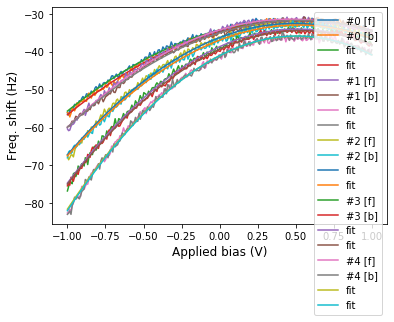

In [9]:
def parabola(x, a, b, c):
    return a*x**2 + b* x + c 

fit_params=[]

#mpl.style.use('default') #set style for plots (default, classic, seaborn-colorblind)
for i in range(nfiles):
    plt.plot(bias[i], delta_f_fwd[i], label = '#'+str(i)+' [f]');
    plt.plot(bias[i], delta_f_bwd[i], label = '#'+str(i)+' [b]');
    
    fit_params_dummy, pcov = scipy.optimize.curve_fit(parabola, bias[i], delta_f_fwd[i])
    y_fit = parabola(bias[i], *fit_params_dummy)
    plt.plot(bias[i], y_fit, label = 'fit')
    fit_params.append(fit_params_dummy)
    
    fit_params_dummy, pcov = scipy.optimize.curve_fit(parabola, bias[i], delta_f_bwd[i])
    y_fit = parabola(bias[i], *fit_params_dummy)
    plt.plot(bias[i], y_fit, label = 'fit')
    fit_params.append(fit_params_dummy)

plt.xlabel('Applied bias (V)', fontsize = 12)
plt.ylabel('Freq. shift (Hz)', fontsize = 12)
plt.legend(ncol = 1, loc = 'upper right', fontsize = 10)

#plt.axis([-350,560,0,1.1])
#plt.tick_params(labelsize = 12, left = 'off', labelleft = 'off')
#plt.legend(ncol = 2, loc = 'upper right', fontsize = 10)
plt.show()

In [11]:
fit_params

[array([-10.94573632,  10.52818458, -34.15008654]),
 array([-10.81318931,  11.16158681, -34.61618709]),
 array([-13.39360583,  12.34534445, -34.13789408]),
 array([-12.26734577,  12.69980249, -34.93142405]),
 array([-15.70383909,  15.31045455, -36.16202476]),
 array([-15.0815422 ,  15.54592281, -36.85369507]),
 array([-17.84255476,  18.24018355, -38.58251649]),
 array([-17.18543222,  18.45436232, -39.29378157]),
 array([-20.17663999,  20.4157526 , -40.97384994]),
 array([-20.40024191,  20.61564788, -40.96714253])]

In [12]:
z_disp = [];
defl_fwd = [];
defl_bwd = [];
for n in range(nfiles): 
    with open(file_name_z[n], "rb") as data_file:
        #string = b'[DATA]'
        dummy_file = data_file.read()
        #print(file)

        
        position = dummy_file.find(b'[DATA]')
        data_file.seek(position)
        data_file.readline()
        data_table = data_file.read().decode('ascii')
    db = pd.read_csv(StringIO(data_table), sep='\t')
    z_disp.append(db['Z rel (m)'])
    defl_fwd.append(db['Vert. Deflection (V)'])
    defl_bwd.append(db['Vert. Deflection [bwd] (V)'])

In [13]:
db.head()

,Z rel (m),Vert. Deflection (V),OC D1 Phase (deg),OC D1 Amplitude (m),OC M1 Freq. Shift (Hz),Vert. Deflection [bwd] (V),OC D1 Phase [bwd] (deg),OC D1 Amplitude [bwd] (m),OC M1 Freq. Shift [bwd] (Hz)
0,1.000000e-08,0.073824,0.034127,2.056200e-08,-24.010904,0.255771,-0.760578,1.814835e-09,-150.40179
1,9.882353e-09,0.074447,0.087594,2.060577e-08,-23.807955,0.265665,0.006576,1.572470e-09,-130.80934
2,9.764706e-09,0.074367,0.062250,2.062972e-08,-19.771078,0.277996,0.295162,1.312764e-09,-122.05370
3,9.647059e-09,0.074699,0.067015,2.067951e-08,-24.591114,0.283870,0.939179,1.033159e-09,-128.19357
4,9.529412e-09,0.074515,0.036871,2.069970e-08,-24.791767,0.306402,4.064768,5.811138e-10,-122.34328


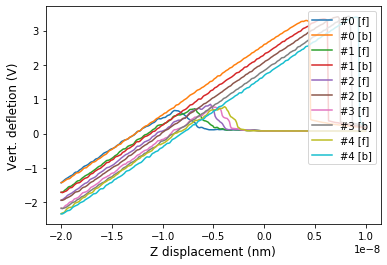

In [30]:
#mpl.style.use('default') #set style for plots (default, classic, seaborn-colorblind)
for i in range(nfiles):
    plt.plot(z_disp[i], defl_fwd[i], label = '#'+str(i)+' [f]');
    plt.plot(z_disp[i], defl_bwd[i], label = '#'+str(i)+' [b]');

plt.xlabel('Z displacement (nm)', fontsize = 12)
plt.ylabel('Vert. defletion (V)', fontsize = 12)
plt.legend(ncol = 1, loc = 'upper right', fontsize = 10)

#plt.axis([-350,560,0,1.1])
#plt.tick_params(labelsize = 12, left = 'off', labelleft = 'off')
#plt.legend(ncol = 2, loc = 'upper right', fontsize = 10)
plt.show()

### Parabola fit general

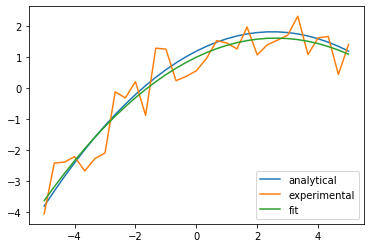

In [21]:
import scipy.optimize

def parabola(x, a, b, c):
    return a*x**2 + b* x + c 

params = [-0.1, 0.5, 1.2]
x = np.linspace(-5,5,31)
y = parabola(x, params[0], params[1], params[2])
plt.plot(x,y, label = 'analytical')

r = np.random.RandomState(42)
y_with_errors = y + r.uniform(-1,1, y.size)
plt.plot(x, y_with_errors, label = 'experimental')

fit_params, pcov = scipy.optimize.curve_fit(parabola, x, y_with_errors)
y_fit = parabola(x, *fit_params)
plt.plot(x,y_fit, label = 'fit')

plt.legend(loc='lower right')
plt.show()

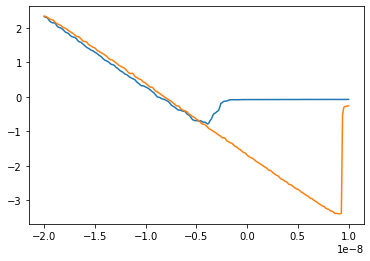

In [24]:
plt.plot(z_disp[i], -defl_fwd[i], label = '#'+str(i)+' [f]');
plt.plot(z_disp[i], -defl_bwd[i], label = '#'+str(i)+' [b]');